# Imports and installing pages - Download data (first time)

In [ ]:
#run it if notebook crased
!pip install tables==3.6.1
!pip install socceraction==0.2.0
!pip install scikit-plot
!pip install shap

     |████████████████████████████████| 4.3 MB 5.1 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 235 kB 7.7 MB/s 
  Created wheel for socceraction: filename=socceraction-0.2.0-py3-none-any.whl size=30656 sha256=c7dc26a1a5895a5d77f39a1eff318ad26f351867040aa3e59b00703cf53db161
  Stored in directory: /root/.cache/pip/wheels/ad/b6/3c/8ae71bd96f4cc8ae86a4ee1fdbd7a6e29fc1e59cec98a543a6
Successfully built socceraction
     |████████████████████████████████| 564 kB 5.1 MB/s 


In [ ]:
#run it if notebook crased
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
import shap
import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import convert_to_spadl
from socceraction.vaep.formula import value

import matplotlib.pyplot as plt
import numpy as np
from scikitplot.metrics import plot_calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

In [ ]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [ ]:
# data_files = {
#     'events': 'https://ndownloader.figshare.com/files/14464685',  # ZIP file containing one JSON file for each competition
#     'matches': 'https://ndownloader.figshare.com/files/14464622',  # ZIP file containing one JSON file for each competition
#     'players': 'https://ndownloader.figshare.com/files/15073721',  # JSON file
#     'teams': 'https://ndownloader.figshare.com/files/15073697'  # JSON file
# }

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# %mkdir -p '/content/gdrive/My Drive/Football_Analytics_Graduation_Project/final_version/dataset'
%cd '/content/gdrive/My Drive/Football_Analytics_Graduation_Project/final_version/dataset'

Mounted at /content/gdrive
/content/gdrive/My Drive/Football_Analytics_Graduation_Project/final_version/dataset


In [ ]:
%cd '/content/gdrive/My Drive/Football_Analytics_Graduation_Project/final_version/dataset'

/content/gdrive/My Drive/Football_Analytics_Graduation_Project/final_version/dataset


In [ ]:
# #Download data and extract it
# for url in tqdm(data_files.values()):
#     url_s3 = urlopen(url).geturl()
#     path = Path(urlparse(url_s3).path)
#     file_name = path.name
#     file_local, _ = urlretrieve(url_s3, file_name)
#     if is_zipfile(file_local):
#         with ZipFile(file_local) as zip_file:
#             zip_file.extractall()

# Preprocess the Wyscout data

The `read_json_file` function reads and returns the content of a given JSON file. The function handles the encoding of special characters (e.g., accents in names of players and teams) that the `pd.read_json` function cannot handle properly.

In [ ]:
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

### Teams and Players (json to h5)

In [ ]:
def teams_players_j_h5(result_file):
    json_teams = read_json_file('teams.json')
    json_players = read_json_file('players.json')

    df_teams = pd.read_json(json_teams)
    df_players = pd.read_json(json_players)

    df_teams.to_hdf(result_file, key='teams', mode='w')
    df_players.to_hdf(result_file, key='players', mode='a')
    print('Number of Teams : ',len(df_teams))
    print('Number of Players : ',len(df_players))
    print('Files generated with append players,teams data : ',result_file)
    print("teams_players_j_h5 done it's work")

Matches of a specific competitions from json to h5

In [ ]:
def matches_j_h5(result_file,competitions):
    dfs_matches = []
    for competition in competitions:
        competition_name = competition.replace(' ', '_')
        file_matches = f'matches_{competition_name}.json'
        json_matches = read_json_file(file_matches)
        df_matches = pd.read_json(json_matches)
        dfs_matches.append(df_matches)
    df_matches = pd.concat(dfs_matches)
    df_matches.to_hdf(result_file, key='matches', mode='a')
    print('Append data of matches of each competition in file : ',result_file)
    print('Number of Matches : ',len(df_matches))
    print("matches_j_h5 done it's work")

In [ ]:
#view matches of a specific competition
# file_matches = f'matches_England.json'
# json_matches = read_json_file(file_matches)
# df_matches = pd.read_json(json_matches)
# df_matches.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",Regular,364
1,Played,4405654,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",181150,2018-05-13 14:00:00,1628,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381851, 'role': 'referee'}, {'r...",Regular,364
2,Played,4405654,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2018-05-13 14:00:00,1609,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364
3,Played,4405654,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",181150,2018-05-13 14:00:00,1612,Anfield,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385704, 'role': 'referee'}, {'r...",Regular,364
4,Played,4405654,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",181150,2018-05-13 14:00:00,1611,Old Trafford,2500093,"Manchester United - Watford, 1 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381853, 'role': 'referee'}, {'r...",Regular,364


### Events of a specific competitions - assign events of matches to  `events/match_<match-id>` in h5

In [ ]:
def events_j_h5(result_file,competitions,):
    for competition in competitions:
        competition_name = competition.replace(' ', '_')
        file_events = f'events_{competition_name}.json'
        json_events = read_json_file(file_events)
        df_events = pd.read_json(json_events)
        df_events_matches = df_events.groupby('matchId', as_index=False)
        for match_id, df_events_match in df_events_matches:
            df_events_match.to_hdf(result_file, key=f'events/match_{match_id}', mode='a')
        print('Number of Events : ',len(df_events))
   
    print("events_j_h5 done it's work")  

Competitions

In [ ]:
competitions = [
    'England',
   # 'France',
   # 'Germany',
   # 'Italy',
    'Spain',
   # 'European Championship',
    'World Cup'
]

## Info and summary about each competitions

In [ ]:
#England info
teams_players_j_h5('England.h5')
matches_j_h5('England.h5',['England'])
events_j_h5('England.h5',['England'])


Number of Teams :  142
Number of Players :  3603
Files generated with append players,teams data :  England.h5
teams_players_j_h5 done it's work
Append data of matches of each competition in file :  England.h5
Number of Matches :  380
matches_j_h5 done it's work
Number of Events :  643150
events_j_h5 done it's work


In [ ]:
#France info
teams_players_j_h5('France.h5')
matches_j_h5('France.h5',['France'])
events_j_h5('France.h5',['France'])

Number of Teams :  142
Number of Players :  3603
teams_players_j_h5 done it's work
Number of Matches :  380
matches_j_h5 done it's work
Number of Events :  632807
events_j_h5 done it's work


In [ ]:
#Germany info
teams_players_j_h5('Germany.h5')
matches_j_h5('Germany.h5',['Germany'])
events_j_h5('Germany.h5',['Germany'])

Number of Teams :  142
Number of Players :  3603
teams_players_j_h5 done it's work
Number of Matches :  306
matches_j_h5 done it's work
Number of Events :  519407
events_j_h5 done it's work


In [ ]:
#Italy info
teams_players_j_h5('Italy.h5')
matches_j_h5('Italy.h5',['Italy'])
events_j_h5('Italy.h5',['Italy'])

Number of Teams :  142
Number of Players :  3603
teams_players_j_h5 done it's work
Number of Matches :  380
matches_j_h5 done it's work
Number of Events :  647372
events_j_h5 done it's work


In [ ]:
#Spain info
teams_players_j_h5('Spain.h5')
matches_j_h5('Spain.h5',['Spain'])
events_j_h5('Spain.h5',['Spain'])

Number of Teams :  142
Number of Players :  3603
teams_players_j_h5 done it's work
Number of Matches :  380
matches_j_h5 done it's work
Number of Events :  628659
events_j_h5 done it's work


In [ ]:
#European Championship info
teams_players_j_h5('European_Championship.h5')
matches_j_h5('European_Championship.h5',['European Championship'])
events_j_h5('European_Championship.h5',['European Championship'])

Number of Teams :  142
Number of Players :  3603
teams_players_j_h5 done it's work
Number of Matches :  51
matches_j_h5 done it's work
Number of Events :  78140
events_j_h5 done it's work


In [ ]:
#World Cup info
teams_players_j_h5('World_Cup.h5')
matches_j_h5('World_Cup.h5',['World Cup'])
events_j_h5('World_Cup.h5',['World Cup'])

Number of Teams :  142
Number of Players :  3603
teams_players_j_h5 done it's work
Number of Matches :  64
matches_j_h5 done it's work
Number of Events :  101759
events_j_h5 done it's work


## Convert the data to the SPADL representation

In [ ]:
def convert_h5_spadl(result_file,competitions):
    teams_players_j_h5(result_file)
    matches_j_h5(result_file,competitions)
    events_j_h5(result_file,competitions)
    convert_to_spadl(result_file, 'all_spadl.h5')
    print("convert_h5_spadl done it's work")  

# result file is for each competition and the same name with pre 'spadl_' is the output file 
#current_competition = competitions[0].replace(' ', '_')
result_file = 'all.h5'

convert_h5_spadl(result_file,competitions)    

Number of Teams :  142
Number of Players :  3603
Files generated with append players,teams data :  all.h5
teams_players_j_h5 done it's work
Append data of matches of each competition in file :  all.h5
Number of Matches :  824
matches_j_h5 done it's work
Number of Events :  643150
Number of Events :  628659
Number of Events :  101759
events_j_h5 done it's work
...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


100%|██████████| 824/824 [01:36<00:00,  8.54game/s]


...Converting events to actions


100%|██████████| 824/824 [11:11<00:00,  1.23game/s]


convert_h5_spadl done it's work


## Value game states

This section generates features and labels for the game states, trains a predictive machine learning model for each label, and values the game states by applying the trained machine learning models.

1. Generate the features to describe the game states;
2. Generate the labels that capture the value of the game states;
3. Compose a dataset by selecting a set of features and the labels of the game states;
4. Train predictive machine learning models using the dataset;
5. Value the game states using the trained predictive machine learning model.


In [ ]:
#run it if notebook crashed
result_file = 'all.h5'
result_file_spadl='all_spadl.h5'
def read_spadl_keys(result_file=result_file):
    df_games = pd.read_hdf(result_file, key='games')
    df_actiontypes = pd.read_hdf(result_file, key='actiontypes')
    df_bodyparts = pd.read_hdf(result_file, key='bodyparts')
    df_results = pd.read_hdf(result_file, key='results')
    print("read_spadl_keys done it's work")
    return df_games,df_actiontypes,df_bodyparts,df_results
df_games,df_actiontypes,df_bodyparts,df_results = read_spadl_keys(result_file_spadl)

read_spadl_keys done it's work


### view dataframes from spadl file

In [ ]:
#details over every game (game_date, home and away teams)
df_games.head()

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
0,2500089,364,181150,2018-05-13 14:00:00,1646,1659
1,2500090,364,181150,2018-05-13 14:00:00,1628,1627
2,2500091,364,181150,2018-05-13 14:00:00,1673,1609
3,2500092,364,181150,2018-05-13 14:00:00,1612,1651
4,2500093,364,181150,2018-05-13 14:00:00,1611,1644


In [ ]:
#22 types of actions
df_actiontypes.head()

,type_id,type_name
0,0,pass
1,1,cross
2,2,throw_in
3,3,freekick_crossed
4,4,freekick_short


In [ ]:
# 3 parts for body
df_bodyparts.head()

,bodypart_id,bodypart_name
0,0,foot
1,1,head
2,2,other


In [ ]:
# 6 results of actions
df_results.head(10)

,result_id,result_name
0,0,fail
1,1,success
2,2,offside
3,3,owngoal
4,4,yellow_card
5,5,red_card


# Generate game states from actions, then generate features and labels

In [ ]:
#run it if notebook crased
nb_prev_actions = 3

functions_features = [
    features.actiontype_onehot, #Get the one-hot-encoded type of each action
    features.bodypart_onehot, #Get the one-hot-encoded bodypart of each action
    features.result_onehot, #Get the one-hot-encode result of each action. 
    features.goalscore, #Get the number of goals scored by each team after the action
    features.startlocation, #Get the location where each action started
    features.endlocation,#Get the location where each action ended
    features.movement, #Get the distance covered by each action
    features.space_delta, #Get the distance covered between the last and previous actions.
    features.startpolar, #Get the polar coordinates of each action’s start location.
    features.endpolar,#Get the polar coordinates of each action’s end location.
    features.team, #Check whether the possession changed during the game state.
    features.time_delta #Get the number of seconds between the last and previous actions
]

The following cell generates game states from consecutive actions in each game and computes the features for each game state.

1. Obtain the actions for the game (i.e., `df_actions`) by looping through the games;
2. Construct game states of a given length from the actions (i.e., `dfs_gamestates`);
3. Compute the features for the constructed game states (i.e., `df_features`) by looping through the list of *feature generators*.

In [ ]:
#Don't run it if notebook crased
import socceraction.vaep.features as features


def generate_features(df_games=df_games,df_actiontypes=df_actiontypes,df_bodyparts=df_bodyparts,df_results=df_results,
                    result_file_spadl=result_file_spadl):
    for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
        game_id = game['game_id']
        df_actions = pd.read_hdf(result_file_spadl, key=f'actions/game_{game_id}')
        #merge action types,bodyparts,results with actions
        df_actions = (df_actions
            .merge(df_actiontypes, how='left')
            .merge(df_results, how='left')
            .merge(df_bodyparts, how='left')
            .reset_index(drop=True)
        )
        
        dfs_gamestates = features.gamestates(df_actions, nb_prev_actions=nb_prev_actions)
        #check home,away teams's ids with game_state id and change start_x,end_x,start_y,end_y 
        dfs_gamestates = features.play_left_to_right(dfs_gamestates, game['home_team_id'])
        df_features = pd.concat([function(dfs_gamestates) for function in functions_features], axis=1)
        df_features.to_hdf('all_features.h5', key=f'game_{game_id}')
    print('features is generated for competitions ' )
generate_features()

  0%|          | 0/824 [00:00<?, ?it/s]

features is generated for competitions 


## Generate game state labels

In [ ]:
functions_labels = [
    labels.scores, #Determine whether the team possessing the ball scored a goal within the next x(default=10) actions.
    labels.concedes #Determine whether the team possessing the ball conceded a goal within the next x(default=10) actions.
]

The following cell computes the labels for each action:

In [ ]:
def generate_labels(df_games=df_games,df_actiontypes=df_actiontypes,df_bodyparts=df_bodyparts,df_results=df_results,
                    result_file_spadl=result_file_spadl):
        for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
            game_id = game['game_id']
            df_actions = pd.read_hdf(result_file_spadl, key=f'actions/game_{game_id}')
            df_actions = (df_actions
                .merge(df_actiontypes, how='left')
                .merge(df_results, how='left')
                .merge(df_bodyparts, how='left')
                .reset_index(drop=True)
            )
            df_labels = pd.concat([function(df_actions) for function in functions_labels], axis=1)
            df_labels.to_hdf('all_labels.h5', key=f'game_{game_id}')
        print('labels file is generated for competitions  ' )

generate_labels()

  0%|          | 0/824 [00:00<?, ?it/s]

2500089
labels file is generated for competitions  


### Plot Actions


In [ ]:
!pip install matplotsoccer

  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-py3-none-any.whl size=5983 sha256=73cdd1d761dc514e4194655e2256bcdeb3735addeffc3b3af3d3bde1b6c2ca11
  Stored in directory: /root/.cache/pip/wheels/be/6f/64/335f5a5e7763b284f2f7d8893f20338de4d9f73794fe85ea7d
Successfully built matplotsoccer


In [ ]:
import matplotsoccer
def plot_actions(df_actions_to_plot):
    matplotsoccer.actions(
        location=df_actions_to_plot[['start_x', 'start_y', 'end_x', 'end_y']],
        action_type=df_actions_to_plot['type_name'],
        # team=df_actions_to_plot['team_name'],
        result=df_actions_to_plot['result_name'] == 'success',
        label=df_actions_to_plot[['nice_time', 'type_name', 'short_name', 'short_team_name']],
        labeltitle=['time', 'actiontype', 'player', 'team'],
        zoom=False,
        figsize=8)

In [ ]:
df_actions = pd.read_hdf(result_file_spadl, key=f'actions/game_2500089')
df_actions = (df_actions
              .merge(df_actiontypes, how='left')
              .merge(df_results, how='left')
              .merge(df_bodyparts, how='left')
              .reset_index(drop=True)
          )
print(df_actions.columns)
for i in range(3):
    df_actions_to_plot = df_actions[400-i:402]
    plot_actions(df_actions_to_plot)

Index(['game_id', 'period_id', 'time_seconds', 'team_id', 'player_id',
       'start_x', 'start_y', 'end_x', 'end_y', 'bodypart_id', 'type_id',
       'result_id', 'type_name', 'result_name', 'bodypart_name'],
      dtype='object')


KeyError: ignored

# Generate dataset

The following cell generates a list of names for the features to be included in the dataset.

In [ ]:
# #run it if notebook crased
# nb_prev_actions = 3

# functions_features = [
#     features.actiontype_onehot, #Get the one-hot-encoded type of each action
#     features.bodypart_onehot, #Get the one-hot-encoded bodypart of each action
#     features.result_onehot, #Get the one-hot-encode result of each action. 
#     features.goalscore, #Get the number of goals scored by each team after the action
#     features.startlocation, #Get the location where each action started
#     features.endlocation,#Get the location where each action ended
#     features.movement, #Get the distance covered by each action
#     features.space_delta, #Get the distance covered between the last and previous actions.
#     features.startpolar, #Get the polar coordinates of each action’s start location.
#     features.endpolar,#Get the polar coordinates of each action’s end location.
#     features.team, #Check whether the possession changed during the game state.
#     features.time_delta #Get the number of seconds between the last and previous actions
# ]

AttributeError: ignored

In [ ]:
#run it if notebook crased
import socceraction.vaep.features as features
columns_features = features.feature_column_names(functions_features, nb_prev_actions=nb_prev_actions)
columns_labels = [
    'scores',
    'concedes'
]

Load dataframes

In [ ]:
#run it if notebook crashed
result_file = 'all.h5'
result_file_spadl='all_spadl.h5'
def read_spadl_keys(result_file=result_file):
    df_games = pd.read_hdf(result_file, key='games')
    df_actiontypes = pd.read_hdf(result_file, key='actiontypes')
    df_bodyparts = pd.read_hdf(result_file, key='bodyparts')
    df_results = pd.read_hdf(result_file, key='results')
    print("read_spadl_keys done it's work")
    return df_games,df_actiontypes,df_bodyparts,df_results
df_games,df_actiontypes,df_bodyparts,df_results = read_spadl_keys(result_file_spadl)

read_spadl_keys done it's work


The following cell obtains the relevant features for each game and stores them in the `df_features` `DataFrame` object.

In [ ]:
#run it if notebook crased
result_file_spadl='all_spadl.h5'
def generate_dataset(result_file_spadl=result_file_spadl):
    dfs_features = []
    dfs_labels = []
    for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
        game_id = game['game_id']
        df_features = pd.read_hdf('all_features.h5', key=f'game_{game_id}')
        dfs_features.append(df_features[columns_features])
    df_features = pd.concat(dfs_features).reset_index(drop=True)

    for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
        game_id = game['game_id']
        df_labels = pd.read_hdf('all_labels.h5', key=f'game_{game_id}')
        dfs_labels.append(df_labels[columns_labels])
    df_labels = pd.concat(dfs_labels).reset_index(drop=True)
    print('dataset is generated for competitions ')
    return df_features,df_labels
df_features,df_labels=generate_dataset()

  0%|          | 0/824 [00:00<?, ?it/s]

  0%|          | 0/824 [00:00<?, ?it/s]

dataset is generated for competitions 


In [ ]:
df_features.head(10)

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,type_interception_a0,type_shot_a0,type_shot_penalty_a0,type_shot_freekick_a0,type_keeper_save_a0,type_keeper_claim_a0,type_keeper_punch_a0,type_keeper_pick_up_a0,type_clearance_a0,type_bad_touch_a0,type_non_action_a0,type_dribble_a0,type_goalkick_a0,type_pass_a1,type_cross_a1,type_throw_in_a1,type_freekick_crossed_a1,type_freekick_short_a1,type_corner_crossed_a1,type_corner_short_a1,type_take_on_a1,type_foul_a1,type_tackle_a1,type_interception_a1,type_shot_a1,type_shot_penalty_a1,type_shot_freekick_a1,type_keeper_save_a1,type_keeper_claim_a1,type_keeper_punch_a1,...,start_y_a1,start_x_a2,start_y_a2,end_x_a0,end_y_a0,end_x_a1,end_y_a1,end_x_a2,end_y_a2,dx_a0,dy_a0,movement_a0,dx_a1,dy_a1,movement_a1,dx_a2,dy_a2,movement_a2,dx_a01,dy_a01,mov_a01,dx_a02,dy_a02,mov_a02,start_dist_to_goal_a0,start_angle_to_goal_a0,start_dist_to_goal_a1,start_angle_to_goal_a1,start_dist_to_goal_a2,start_angle_to_goal_a2,end_dist_to_goal_a0,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,34.00,52.50,34.00,42.00,37.40,42.00,37.40,42.00,37.40,-10.50,3.40,11.036757,-10.50,3.40,11.036757,-10.50,3.40,11.036757,-1.050000e+01,3.400000e+00,1.103676e+01,-10.50,3.400000e+00,11.036757,52.500000,0.000000,52.500000,0.000000,52.500000,0.000000,63.091679,0.053916,63.091679,0.053916,63.091679,0.053916,True,True,0.000000,0.000000
1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,34.00,52.50,34.00,40.95,57.80,42.00,37.40,42.00,37.40,-1.05,20.40,20.427004,-10.50,3.40,11.036757,-10.50,3.40,11.036757,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000,63.091679,0.053916,52.500000,0.000000,52.500000,0.000000,68.328929,0.355773,63.091679,0.053916,63.091679,0.053916,True,True,1.997756,1.997756
2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,37.40,52.50,34.00,32.55,47.60,40.95,57.80,42.00,37.40,-8.40,-10.20,13.213629,-1.05,20.40,20.427004,-10.50,3.40,11.036757,0.000000e+00,0.000000e+00,0.000000e+00,1.05,-2.040000e+01,20.427004,68.328929,0.355773,63.091679,0.053916,52.500000,0.000000,73.715416,0.185556,68.328929,0.355773,63.091679,0.053916,True,True,0.771744,2.769500
3,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,57.80,42.00,37.40,69.30,48.96,32.55,47.60,40.95,57.80,36.75,1.36,36.775156,-8.40,-10.20,13.213629,-1.05,20.40,20.427004,0.000000e+00,0.000000e+00,0.000000e+00,8.40,1.020000e+01,13.213629,73.715416,0.185556,68.328929,0.355773,63.091679,0.053916,38.707772,0.396818,73.715416,0.185556,68.328929,0.355773,True,True,2.174464,2.946208
4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,47.60,40.95,57.80,74.55,55.76,69.30,48.96,32.55,47.60,5.25,6.80,8.590838,36.75,1.36,36.775156,-8.40,-10.20,13.213629,0.000000e+00,0.000000e+00,0.000000e+00,-36.75,-1.360000e+00,36.775156,38.707772,0.396818

In [ ]:
df_labels.head(10)

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,False
9,False,False


# Split dataset

To avoid underfitting, we define an expressive set of features and use a machine learning algorithm that learns a model that can capture complex relationships between these features. To avoid overfitting, we apply cross-validation to assess how well a candidate model would perform in practice and apply regularization techniques to keep the learned model as simple as possible

In [ ]:
#Note we have two targets columns
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df_features,
    df_labels,
    test_size=0.10,
    random_state=42,
    stratify=df_labels['scores'].astype(str) + '_' + df_labels['concedes'].astype(str)
) 
features_list = df_features.columns
# stratify for both targets

check that train and test sets has the sam proportion for each class

In [ ]:
df_y_train['scores'].mean()

0.01564185141203142

In [ ]:
df_y_test['scores'].mean()

0.015641834692935203

In [ ]:
df_y_train['concedes'].mean()

0.005031173609158938

In [ ]:
df_y_test['concedes'].mean()

0.005031168231491458

In [ ]:
len(df_features.columns)

142

# XGB (first time)

## Train classifiers

The following cell trains an XGBoost classifier for each label using the computed features. For each label:
1. Construct an XGBoost classifier with default hyperparameters;
2. Train the classifier using the computed features and the label;
3. Store the trained classifier in the `models` `dict`.

In [ ]:
features = df_features.columns
labels = [
    'scores',
    'concedes'
]
def train_XGB_model(df_X_train=df_X_train,df_y_train=df_y_train,features=features,labels=labels):
    models = {}
    for label in tqdm(labels):
        model = XGBClassifier(
            eval_metric='logloss',
            use_label_encoder=False,
            n_estimators=10,#100,#10
            max_depth=3
        )
        model.fit(df_X_train[features], df_y_train[label])
        models[label] = model
    return models
models = train_XGB_model()

  0%|          | 0/2 [00:00<?, ?it/s]

Save model

In [ ]:
import joblib

# save
joblib.dump(models['scores'], "scores_xgb_model.pkl") 
joblib.dump(models['concedes'], "concedes_xgb_model.pkl") 

#load if needed
# joblib.load("scores_xgb_model.pkl")
# joblib.load("concedes_xgb_model.pkl")


['concedes_xgb_model.pkl']

In [ ]:
df_X_train[features].shape

(935567, 142)

In [ ]:
df_X_test[features].shape

(103952, 142)

## Check feature importance

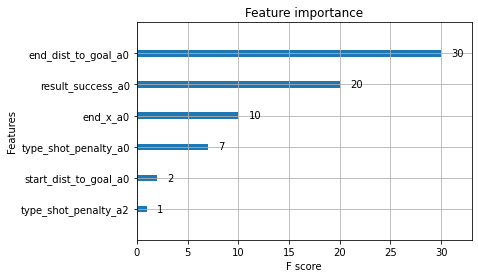

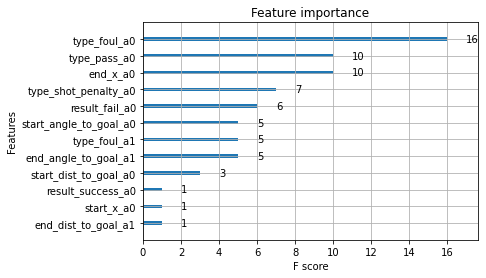

In [ ]:
from xgboost import  plot_importance
for label in labels:
    plot_importance(models[label])

### Investigate SHAP values

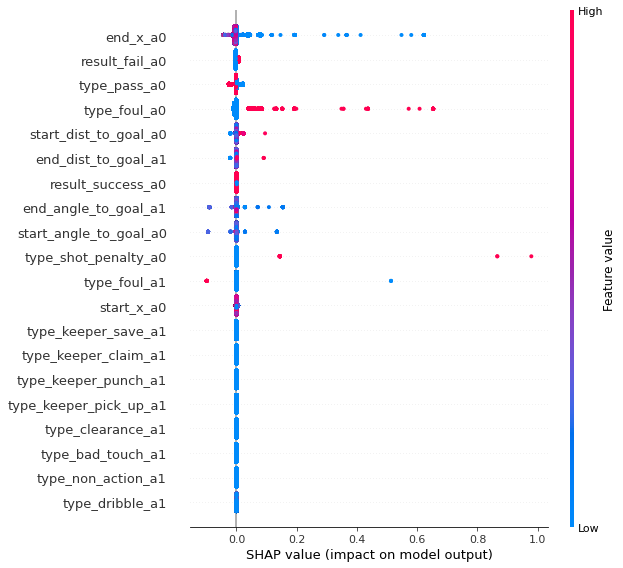

In [ ]:
explainer = shap.TreeExplainer(models[label])
shap_values = explainer.shap_values(df_X_test[features])
shap.summary_plot(shap_values, df_X_test[features])

## Estimate probabilities

The following cell predicts the labels for the game states using the trained XGBoost classifier. For each label:
1. Retrieve the model for the label;
2. Estimate the probabilities of the labels being `False` and `True` given the computed features;
3. Keep the probabilities for the `True` label;
4. Store the probabilities as a `Series` object in the `dfs_predictions` `dict`.

In [ ]:
features = df_features.columns
labels = [
    'scores',
    'concedes'
]
def predict_model(models=models, df_X_test=df_X_test,features=features):
    dfs_predictions = {}
    for label in tqdm(labels):
        model = models[label]
        probabilities = model.predict_proba(df_X_test[features])
        predictions = probabilities[:, 1] #get True labels only
        dfs_predictions[label] = pd.Series(predictions)
    df_predictions = pd.concat(dfs_predictions, axis=1)
    print('predict_model is done!')
    return df_predictions


df_predictions = predict_model()


  0%|          | 0/2 [00:00<?, ?it/s]

predict_model is done!


In [ ]:
df_predictions.head(10)

,scores,concedes
0,0.189342,0.181177
1,0.183821,0.181801
2,0.189342,0.181177
3,0.183821,0.217126
4,0.183821,0.181801
5,0.184216,0.181177
6,0.183821,0.183518
7,0.189342,0.181177
8,0.183821,0.181177
9,0.184216,0.181177


## Evaluate Probabilities

### [Brier score less](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html)
*   we will use brier score loss, since predictions in our case are probabilites (it is equivalent to cost function)


*   The smaller the Brier score loss, the better, hence the naming with “loss”. The Brier score measures the mean squared difference between the predicted probability and the actual outcome

In [ ]:
from sklearn.metrics import brier_score_loss
brier_score_loss( y_true=df_y_test['scores'],y_prob=df_predictions['scores'])

0.04343915484026909

In [ ]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_predictions['concedes']
)

0.03634725076957539

In [ ]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(df_y_test['scores'],df_predictions['scores'])
auc(fpr, tpr)

0.7452406411854122

In [ ]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(df_y_test['concedes'],df_predictions['concedes'])
auc(fpr, tpr)

0.7233248486824643

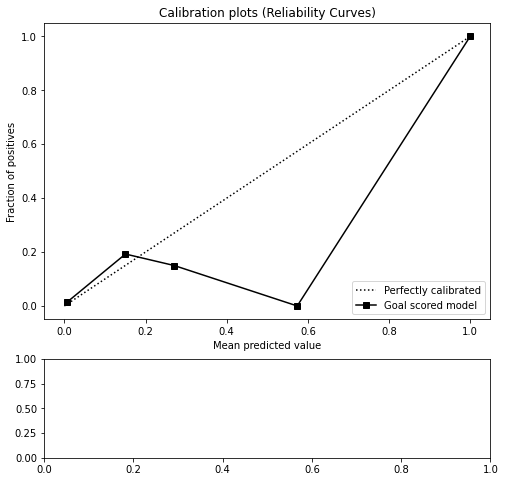

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={
        'height_ratios': [3, 1]
    }
)
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1
)
# df_predictions['scores'].plot.hist(
#     range=(0, 1),
#     bins=50,
#     ax=ax2
# )
#https://www.geeksforgeeks.org/calibration-curves/

**Note : From the graph, we can clearly see that the XGB need some optimziation**

# .
<br>
<br>
<hr>
<br>
<br>


# select features based on check importance in cell below - ***Choose 14 columns only***

In [ ]:
# we check feature importance below and modify them here
features_list = [
    'start_dist_to_goal_a0',
    'end_dist_to_goal_a0',
    'start_dist_to_goal_a1',
    'end_dist_to_goal_a1',
    'start_dist_to_goal_a2',
    'end_dist_to_goal_a2',
    'start_angle_to_goal_a0',
    'end_angle_to_goal_a0',
    'start_angle_to_goal_a1',
    'end_angle_to_goal_a1',
    'start_angle_to_goal_a2',
    'end_angle_to_goal_a2',
    'team_1',
    'team_2'
]


In [ ]:
df_features = df_features[['start_dist_to_goal_a0',
    'end_dist_to_goal_a0',
    'start_dist_to_goal_a1',
    'end_dist_to_goal_a1',
    'start_dist_to_goal_a2',
    'end_dist_to_goal_a2',
    'start_angle_to_goal_a0',
    'end_angle_to_goal_a0',
    'start_angle_to_goal_a1',
    'end_angle_to_goal_a1',
    'start_angle_to_goal_a2',
    'end_angle_to_goal_a2',
    'team_1',
    'team_2']]

# Split dataset

To avoid underfitting, we define an expressive set of features and use a machine learning algorithm that learns a model that can capture complex relationships between these features. To avoid overfitting, we apply cross-validation to assess how well a candidate model would perform in practice and apply regularization techniques to keep the learned model as simple as possible

In [ ]:
#Note we have two targets columns
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df_features,
    df_labels,
    test_size=0.10,
    random_state=42,
    stratify=df_labels['scores'].astype(str) + '_' + df_labels['concedes'].astype(str)
) 
features_list = df_features.columns
# stratify for both targets

check that train and test sets has the sam proportion for each class

In [ ]:
df_y_train['scores'].mean()

0.01564185141203142

In [ ]:
df_y_test['scores'].mean()

0.015641834692935203

In [ ]:
df_y_train['concedes'].mean()

0.005031173609158938

In [ ]:
df_y_test['concedes'].mean()

0.005031168231491458

In [ ]:
len(df_features.columns)

14

# 1 - XGB (first time)

## Train classifiers

The following cell trains an XGBoost classifier for each label using the computed features. For each label:
1. Construct an XGBoost classifier with default hyperparameters;
2. Train the classifier using the computed features and the label;
3. Store the trained classifier in the `models` `dict`.

In [ ]:
features = df_features.columns
labels = [
    'scores',
    'concedes'
]
def train_XGB_model(df_X_train=df_X_train,df_y_train=df_y_train,features=features,labels=labels):
    models = {}
    for label in tqdm(labels):
        model = XGBClassifier(
            eval_metric='logloss',
            use_label_encoder=False,
            n_estimators=10,#100,#10
            max_depth=3
        )
        model.fit(df_X_train[features], df_y_train[label])
        models[label] = model
    return models
models = train_XGB_model()

  0%|          | 0/2 [00:00<?, ?it/s]

Save model

In [ ]:
import joblib

# save
joblib.dump(models['scores'], "scores_xgb_model.pkl") 
joblib.dump(models['concedes'], "concedes_xgb_model.pkl") 

#load if needed
# joblib.load("scores_xgb_model.pkl")
# joblib.load("concedes_xgb_model.pkl")


['concedes_xgb_model.pkl']

In [ ]:
df_X_train[features].shape

(935567, 14)

In [ ]:
df_X_test[features].shape

(103952, 14)

## Check feature importance

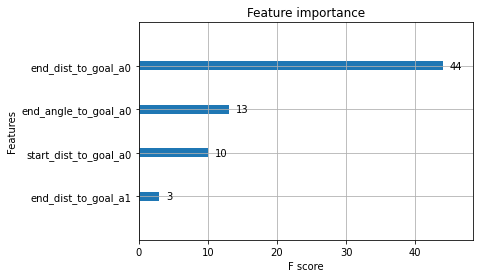

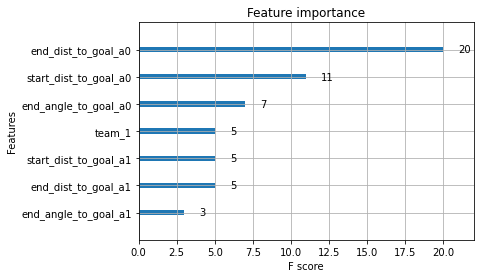

In [ ]:
from xgboost import  plot_importance
for label in labels:
    plot_importance(models[label])

### Investigate SHAP values

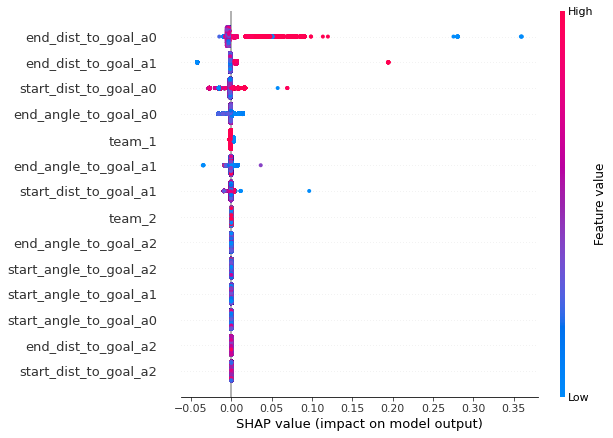

In [ ]:
explainer = shap.TreeExplainer(models[label])
shap_values = explainer.shap_values(df_X_test[features])
shap.summary_plot(shap_values, df_X_test[features])

## Estimate probabilities

The following cell predicts the labels for the game states using the trained XGBoost classifier. For each label:
1. Retrieve the model for the label;
2. Estimate the probabilities of the labels being `False` and `True` given the computed features;
3. Keep the probabilities for the `True` label;
4. Store the probabilities as a `Series` object in the `dfs_predictions` `dict`.

In [ ]:
features = df_features.columns
labels = [
    'scores',
    'concedes'
]
def predict_model(models=models, df_X_test=df_X_test,features=features):
    dfs_predictions = {}
    for label in tqdm(labels):
        model = models[label]
        probabilities = model.predict_proba(df_X_test[features])
        predictions = probabilities[:, 1] #get True labels only
        dfs_predictions[label] = pd.Series(predictions)
    df_predictions = pd.concat(dfs_predictions, axis=1)
    print('predict_model is done!')
    return df_predictions


df_predictions = predict_model()


  0%|          | 0/2 [00:00<?, ?it/s]

predict_model is done!


In [ ]:
df_predictions.head(10)

,scores,concedes
0,0.189045,0.181229
1,0.183757,0.182637
2,0.189045,0.181229
3,0.183757,0.188290
4,0.183757,0.182934
5,0.184195,0.181669
6,0.183757,0.188290
7,0.189045,0.181229
8,0.183757,0.181229
9,0.184195,0.181229


## Evaluate Probabilities

### [Brier score less](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html)
*   we will use brier score loss, since predictions in our case are probabilites (it is equivalent to cost function)


*   The smaller the Brier score loss, the better, hence the naming with “loss”. The Brier score measures the mean squared difference between the predicted probability and the actual outcome

In [ ]:
from sklearn.metrics import brier_score_loss
brier_score_loss( y_true=df_y_test['scores'],y_prob=df_predictions['scores'])

0.04448682935719405

In [ ]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_predictions['concedes']
)

0.03643242357693051

In [ ]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(df_y_test['scores'],df_predictions['scores'])
auc(fpr, tpr)

0.7386895719464396

In [ ]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(df_y_test['concedes'],df_predictions['concedes'])
auc(fpr, tpr)

0.693710265807636

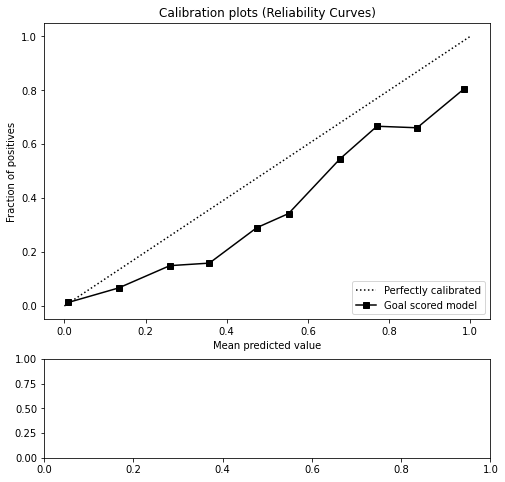

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={
        'height_ratios': [3, 1]
    }
)
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1
)
# df_predictions['scores'].plot.hist(
#     range=(0, 1),
#     bins=50,
#     ax=ax2
# )
#https://www.geeksforgeeks.org/calibration-curves/

**Note : From the graph, we can clearly see that the XGB need some optimziation**

# XGB Optimization - Tuning (don't run it again)

## Tuning using randomized search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

space = dict()
space['n_estimators'] = [50,100]
space['max_depth'] = [3,4]

features = features_list
labels = [
    'scores',
    # 'concedes'
]
def train_optimized_XGB_model(df_X_train=df_X_train,df_y_train=df_y_train,features=features,labels=labels):
    models = {}
    for label in tqdm(labels):
        model = RandomizedSearchCV(
            estimator=XGBClassifier(
                  eval_metric='logloss',
                  use_label_encoder=False
            ),
            param_distributions=space,
            scoring='neg_brier_score',
            refit=True,  # train final model on full training set using best hyperparameters
            verbose=10,
            n_jobs=1,
            random_state=1
         )
        model.fit(df_X_train[features], df_y_train[label])
        models[label] = model
    return models
models_cv = train_optimized_XGB_model()

  0%|          | 0/1 [00:00<?, ?it/s]

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 1/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=  43.4s
[CV 2/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 2/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=  42.6s
[CV 3/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 3/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=  43.6s
[CV 4/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 4/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=  46.0s
[CV 5/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 5/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=  44.0s
[CV 1/5; 2/4] START max_depth=3, n_estimators=100...............................
[CV 1/5; 2/4] END max_depth=3, n_estimators=100;,

check best parameters

In [ ]:
model_scores_cv = models_cv['scores']
pd.Series(
    model_scores_cv.best_params_
)

n_estimators    100
max_depth         4
dtype: int64

In [ ]:
pd.DataFrame(
    model_scores_cv.cv_results_
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,43.521174,1.100269,0.407565,0.005657,50,3,"{'n_estimators': 50, 'max_depth': 3}",-0.014313,-0.014341,-0.014308,-0.014330,-0.014377,-0.014333,0.000025,4
1,83.751293,0.718460,0.718413,0.015443,100,3,"{'n_estimators': 100, 'max_depth': 3}",-0.014227,-0.014252,-0.014242,-0.014248,-0.014292,-0.014252,0.000022,2
2,57.381850,0.971444,0.496296,0.010990,50,4,"{'n_estimators': 50, 'max_depth': 4}",-0.014251,-0.014272,-0.014258,-0.014267,-0.014315,-0.014273,0.000022,3
3,112.238482,1.589296,0.943039,0.012456,100,4,"{'n_estimators': 100, 'max_depth': 4}",-0.014194,-0.014212,-0.014208,-0.014216,-0.014265,-0.014219,0.000024,1


In [ ]:
model_scores_cv.best_estimator_


XGBClassifier(eval_metric='logloss', max_depth=4, use_label_encoder=False)

# 2 - Tuned XGB (optimized)

In [ ]:
features = df_features.columns
labels = [
    'scores',
    'concedes'
]
def train_tuned_XGB_model(df_X_train=df_X_train,df_y_train=df_y_train,features=features_list,labels=labels):
    models = {}
    for label in tqdm(labels):
        model = XGBClassifier(
            eval_metric='logloss',
            use_label_encoder=False,
            n_estimators=100,#100,#10
            max_depth=4
        )
        model.fit(df_X_train[features], df_y_train[label])
        models[label] = model
    return models
models = train_tuned_XGB_model()

  0%|          | 0/2 [00:00<?, ?it/s]

save tuned model

In [ ]:
import joblib
tuned_models = models
# save
joblib.dump(tuned_models['scores'], "scores_tuned_xgb_model.pkl") 
joblib.dump(tuned_models['concedes'], "concedes_tuned_xgb_model.pkl") 

#load if needed
# joblib.load("scores_xgb_model.pkl")
# joblib.load("concedes_xgb_model.pkl")


['concedes_tuned_xgb_model.pkl']

## Estimate Probabilites  for XGB after optimization

In [ ]:
df_predictions = predict_model(tuned_models)

  0%|          | 0/2 [00:00<?, ?it/s]

predict_model is done!


In [ ]:
df_predictions.head()

,scores,concedes
0,0.025364,0.002545
1,0.008934,0.004722
2,0.021881,0.002437
3,0.004046,0.014061
4,0.005519,0.008327


## Evaluate Probabilities for XGB after optimization

### [Brier score less](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html)
*   we will use brier score loss, since predictions in our case are probabilites (it is equivalent to cost function)


*   The smaller the Brier score loss, the better, hence the naming with “loss”. The Brier score measures the mean squared difference between the predicted probability and the actual outcome

result with 14 columns

In [ ]:
from sklearn.metrics import brier_score_loss
brier_score_loss( y_true=df_y_test['scores'],y_prob=df_predictions['scores'])

0.01404646162768942

In [ ]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_predictions['concedes']
)

0.004957445037275639

In [ ]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(df_y_test['scores'],df_predictions['scores'])
auc(fpr, tpr)


0.7586114804818278

In [ ]:
fpr, tpr, thresholds = roc_curve(df_y_test['concedes'],df_predictions['concedes'])
auc(fpr, tpr)

0.7032421461211686

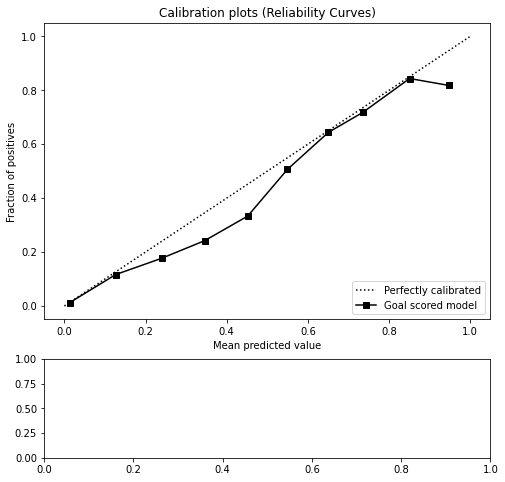

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={
        'height_ratios': [3, 1]
    }
)
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1
)
# df_predictions['scores'].plot.hist(
#     range=(0, 1),
#     bins=50,
#     ax=ax2
# )
#https://www.geeksforgeeks.org/calibration-curves/

**Note : From the graph, we can clearly see that the XGB need some optimziation**

# 3 - Logistic Regression

## Train classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
features = df_features.columns
labels = [
    'scores',
    'concedes'
]
def train_logistic_model(df_X_train=df_X_train,df_y_train=df_y_train,features=features,labels=labels):
    models = {}
    for label in tqdm(labels):
        model = LogisticRegression(
            random_state=0,max_iter=500
        )
        model.fit(df_X_train[features], df_y_train[label])
        models[label] = model
    return models
logistic_models = train_logistic_model()

  0%|          | 0/2 [00:00<?, ?it/s]

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



save Logisitic model

In [ ]:
import joblib
tuned_models = models
# save
joblib.dump(logistic_models['scores'], "scores_logisitic_model.pkl") 
joblib.dump(logistic_models['concedes'], "concedes_logistic_model.pkl") 

#load if needed
# joblib.load("scores_xgb_model.pkl")
# joblib.load("concedes_xgb_model.pkl")


['concedes_logistic_model.pkl']

## estimate probabilities using Logistic regression


In [ ]:
df_predictions = predict_model(logistic_models)

  0%|          | 0/2 [00:00<?, ?it/s]

predict_model is done!


In [ ]:
df_predictions.head()

,scores,concedes
0,0.028858,0.002275
1,0.005177,0.006102
2,0.028198,0.001764
3,0.001217,0.015521
4,0.002577,0.008611


## Evaluate probabilities of logisitic regression

### [Brier score less](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html)
*   we will use brier score loss, since predictions in our case are probabilites (it is equivalent to cost function)


*   The smaller the Brier score loss, the better, hence the naming with “loss”. The Brier score measures the mean squared difference between the predicted probability and the actual outcome

result with 14 columns

In [ ]:
from sklearn.metrics import brier_score_loss
brier_score_loss( y_true=df_y_test['scores'],y_prob=df_predictions['scores'])

0.014896299220311071

In [ ]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_predictions['concedes']
)

0.004984398017193698

In [ ]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(df_y_test['scores'],df_predictions['scores'])
auc(fpr, tpr)

0.7493859494817219

In [ ]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(df_y_test['concedes'],df_predictions['concedes'])
auc(fpr, tpr)

0.6786702517519384

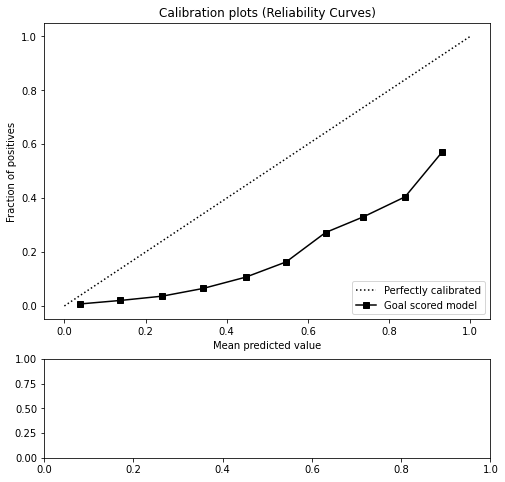

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={
        'height_ratios': [3, 1]
    }
)
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1
)
# df_predictions['scores'].plot.hist(
#     range=(0, 1),
#     bins=50,
#     ax=ax2
# )
#https://www.geeksforgeeks.org/calibration-curves/

**Note : From the graph, we can clearly see that the Logistic is not well calibrated**

# 4 - RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
features = df_features.columns
labels = [
    'scores',
    'concedes'
]
def train_RF_model(df_X_train=df_X_train,df_y_train=df_y_train,features=features_list,labels=labels):
    models = {}
    for label in tqdm(labels):
        model = RandomForestClassifier(
            n_estimators=500,#100,#10
            max_depth=5
        )
        model.fit(df_X_train[features], df_y_train[label])
        models[label] = model
    return models
models = train_RF_model()

  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

save tuned model

In [ ]:
import joblib
tuned_models = models
# save
joblib.dump(tuned_models['scores'], "scores_RF_model.pkl") 
joblib.dump(tuned_models['concedes'], "concedes_RF_model.pkl") 

#load if needed
# joblib.load("scores_xgb_model.pkl")
# joblib.load("concedes_xgb_model.pkl")


## Estimate Probabilites  for XGB after optimization

In [ ]:
rf_model = models
df_predictions = predict_model(rf_model)

In [ ]:
df_predictions.head()

## Evaluate Probabilities for XGB after optimization

### [Brier score less](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html)
*   we will use brier score loss, since predictions in our case are probabilites (it is equivalent to cost function)


*   The smaller the Brier score loss, the better, hence the naming with “loss”. The Brier score measures the mean squared difference between the predicted probability and the actual outcome

result with 14 columns

In [ ]:
from sklearn.metrics import brier_score_loss
brier_score_loss( y_true=df_y_test['scores'],y_prob=df_predictions['scores'])

In [ ]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_predictions['concedes']
)

In [ ]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(df_y_test['scores'],df_predictions['scores'])
auc(fpr, tpr)


In [ ]:
fpr, tpr, thresholds = roc_curve(df_y_test['concedes'],df_predictions['concedes'])
auc(fpr, tpr)

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={
        'height_ratios': [3, 1]
    }
)
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1
)
# df_predictions['scores'].plot.hist(
#     range=(0, 1),
#     bins=50,
#     ax=ax2
# )
#https://www.geeksforgeeks.org/calibration-curves/

**Note : From the graph, we can clearly see that the XGB need some optimziation**

# 5 - Support vector machine (SVM)

In [ ]:
from sklearn import svm
features = df_features.columns
labels = [
    'scores',
    'concedes'
]
def train_RF_model(df_X_train=df_X_train,df_y_train=df_y_train,features=features_list,labels=labels):
    models = {}
    for label in tqdm(labels):
        model = svm.SVC()
        model.fit(df_X_train[features], df_y_train[label])
        models[label] = model
    return models
models = train_RF_model()

  0%|          | 0/2 [00:00<?, ?it/s]

save tuned model

In [ ]:
import joblib
tuned_models = models
# save
joblib.dump(tuned_models['scores'], "scores_svm_model.pkl") 
joblib.dump(tuned_models['concedes'], "concedes_svm_model.pkl") 

#load if needed
# joblib.load("scores_xgb_model.pkl")
# joblib.load("concedes_xgb_model.pkl")


['concedes_svm_model.pkl']

## Estimate Probabilites  for XGB after optimization

In [ ]:
svm_model = models
df_predictions = predict_model(svm_model)

  0%|          | 0/2 [00:00<?, ?it/s]

AttributeError: ignored

In [ ]:
df_predictions.head()

## Evaluate Probabilities for XGB after optimization

### [Brier score less](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html)
*   we will use brier score loss, since predictions in our case are probabilites (it is equivalent to cost function)


*   The smaller the Brier score loss, the better, hence the naming with “loss”. The Brier score measures the mean squared difference between the predicted probability and the actual outcome

result with 14 columns

In [ ]:
from sklearn.metrics import brier_score_loss
brier_score_loss( y_true=df_y_test['scores'],y_prob=df_predictions['scores'])

In [ ]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_predictions['concedes']
)

In [ ]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(df_y_test['scores'],df_predictions['scores'])
auc(fpr, tpr)


In [ ]:
fpr, tpr, thresholds = roc_curve(df_y_test['concedes'],df_predictions['concedes'])
auc(fpr, tpr)

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={
        'height_ratios': [3, 1]
    }
)
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1
)
# df_predictions['scores'].plot.hist(
#     range=(0, 1),
#     bins=50,
#     ax=ax2
# )
#https://www.geeksforgeeks.org/calibration-curves/

**Note : From the graph, we can clearly see that the XGB need some optimziation**